# Deep Learning Computation

Pada chapter 5 ini, akan dibahas mengenai komponen kunci komputasi dalam deep learning, yaitu kontruksi model, akses parameter, dan inisialisasi, merancang layers dan blocks khusus, membaca dan menulis model ke disk, dan memanfaatkan GPU untuk mencapai hasil dengan percepatan yang dramatik.

In [1]:
!pip install d2l
!pip install matplotlib==3.0.2

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.0.2-cp37-cp37m-manylinux1_x86_64.whl (12.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## **Layers dan Blocks**

Kode berikut ini menghasilkan network dengan satu layer tersembunyi yang tehubung penuh dengan 256 unit dan aktivasi ReLU, yang dibarengi oleh output layer yang terhubung penuh dengan 10 unit (tanpa fungsi aktivasi)

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[ 0.3271,  0.2411, -0.0707,  0.0556,  0.0018, -0.1940, -0.2239, -0.2439,
          0.0358,  0.1026],
        [ 0.1533,  0.0781, -0.1266,  0.0252,  0.0458, -0.2297, -0.2295, -0.1013,
         -0.0545,  0.1378]], grad_fn=<AddmmBackward0>)

In this example, we constructed our model by instantiating an **nn.Sequential**, with layers in the order that they should be executed passed as arguments. 

In short, **nn.Sequential** defines a special kind of Module, the class that presents a block in PyTorch. It maintains an ordered list of constituent Modules.

**Note** that each of the two fully-connected layers is an instance of the Linear class which is itself a subclass of Module. 

The forward propagation (forward) function is also remarkably simple: it chains each block in the list together, passing the output of each as the input to the next. 

Note that until now, **we have been invoking our models via the construction net(X)** to obtain their outputs. This is actually just shorthand for net. **__call__(X)**.

###  A Custom Block

Dibuat kode blok dari awal yang sesuai dengan MLP dengan satu layer tersembunyi dengan 256 unit tersembunyi, dan output layer 10 dimensi. 

Perhatikan bahwa kelas MLP yang diperlihatkan mewarisi keals yang mewakili sebuah blok. 

We will heavily rely on the parent class’s functions, supplying only our own constructor (the __init__ function in Python) and the forward propagation function.

In [3]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters, `params` (to be described later)
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # Hidden layer
        self.out = nn.Linear(256, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input `X`
    def forward(self, X):
        # Note here we use the funtional version of ReLU defined in the
        # nn.functional module.
        return self.out(F.relu(self.hidden(X)))

Mari fokus pada fungsi forward propagation. 

Perhatikan bahwa fungsi ini mengambil **X** sebagai input, menghitung representasi tersembunyi dengan fungsi aktivasi yang diterapkan, dan mengeluarkan logitnya.

Dalam implementasi MLP, kedua layer tersebut merupakan variabel instan. Untuk melihat mengapa hal ini masuk akal, **bayangkan membuat instance dua MLP, net1 dan net2, dan melatihnya pada data yang berbeda**.

Secara alami, dapat diharapkan mereka mewakili dua model belajar yang berbeda.

Pertama, fungsi __init__ kami yang disesuaikan memanggil fungsi __init__ kelas induk melalui super().__init__() sehingga kami tidak perlu mengulangi kode boilerplate yang berlaku untuk sebagian besar blok.

kemudian buat instance dua lapisan yang terhubung penuh, menugaskannya ke self.hidden dan self.out.

ketika diimplementasikan operator baru, kita tidak perlu khawatir tentang fungsi backpropagation atau inisialisasi parameter.

Sistem akan menghasilkan fungsi-fungsi ini secara otomatis.

In [4]:
net = MLP()
net(X)

tensor([[ 0.1094, -0.1565,  0.1222, -0.1341, -0.1089,  0.0935,  0.1358,  0.1472,
          0.0794,  0.1645],
        [-0.1085, -0.1963,  0.0652, -0.2284, -0.1470,  0.0506,  0.1743,  0.1691,
          0.0405,  0.0247]], grad_fn=<AddmmBackward0>)

### The Sequential Block

In [5]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Here, `module` is an instance of a `Module` subclass. We save it
            # in the member variable `_modules` of the `Module` class, and its
            # type is OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X

In [6]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.1143, -0.0086,  0.0947,  0.2685,  0.1422, -0.1470, -0.0654,  0.0108,
          0.0327,  0.1134],
        [ 0.1949, -0.0986,  0.1940,  0.2208,  0.2318, -0.1218, -0.0562,  0.2294,
          0.0857,  0.2025]], grad_fn=<AddmmBackward0>)

### Executing Code in the Forward Propagation Function

In [7]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # Use the created constant parameters, as well as the `relu` and `mm`
        # functions
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # Reuse the fully-connected layer. This is equivalent to sharing
        # parameters with two fully-connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In [8]:
net = FixedHiddenMLP()
net(X)

tensor(-0.0322, grad_fn=<SumBackward0>)

In [9]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.0825, grad_fn=<SumBackward0>)

### Efficiency

The avid reader might start to worry about the efficiency of some of these operations. After all, we have lots of dictionary lookups, code execution, and lots of other Pythonic things taking place in what is supposed to be a high-performance deep learning library. The problems of Python’s global interpreter lock are well known. In the context of deep learning, we may worry that our extremely fast GPU(s) might have to wait until a puny CPU runs Python code before it gets another job to run.

### Summary



*   Layers are blocks

*   Many layers can comprise a block

*   Many blocks can comprise a block
*   A block can contain code


*   Blocks take care of lots of housekeeping, including parameter initialization and backpropagation


*   Sequential concatenations of layers and blocks are handled by the Sequential block



## **Parameter Management**

In [10]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.4906],
        [0.4594]], grad_fn=<AddmmBackward0>)

### Parameter Access

Mari kita mulai dengan cara mengakses parameter dari model yang sudah Anda ketahui. Ketika model didefinisikan melalui Sequential class, kami dapat mengakses layer apa pun dengan mengindeks ke dalam model seolah-olah itu adalah daftar. Parameter setiap lapisan berlokasi di atributnya. Kami dapat memeriksa parameter layer yang sepenuhnya terhubung kedua sebagai berikut.

In [11]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.2538,  0.1809,  0.2734, -0.1174,  0.1455, -0.1749, -0.1915,  0.2555]])), ('bias', tensor([0.2022]))])


**The output tells us a few important things**.

**Pertama**, lapisan yang sepenuhnya terhubung sepenuhnya ini berisi dua parameter, masing-masing sesuai dengan bobot dan bias layer.

**Keduanya** disimpan sebagai pengaparan presisi tunggal (float32). Perhatikan bahwa nama-nama parameter memungkinkan kita untuk secara unik mengidentifikasi parameter setiap lapisan, bahkan dalam jaringan yang berisi ratusan lapisan.

#### Targeted Parameters

In [12]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.2022], requires_grad=True)
tensor([0.2022])


In [13]:
net[2].weight.grad == None

True

#### All Parameters at Once

In [14]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [15]:
net.state_dict()['2.bias'].data

tensor([0.2022])

#### Collecting Parameters from Nested Blocks

In [16]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.3361],
        [-0.3361]], grad_fn=<AddmmBackward0>)

In [17]:
# Now that we have designed the network, let us see how it is organized

print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


Karena layer-layer itu bersarang hierarkis, kita juga dapat mengaksesnya seolah-olah mengindeks melalui daftar bersarang. Misalnya, kita dapat **mengakses blok utama pertama, di dalamnya sub-blok kedua, dan di dalam bias lapisan pertama,** dengan sebagai berikut.

In [18]:
rgnet[0][1][0].bias.data

tensor([ 0.1920,  0.2569, -0.4182,  0.3486,  0.4197,  0.1028,  0.1998, -0.3811])

### Parameter Initialization

#### Built-in Initialization

Mulai dengan memanggil inisialisasi bawaan. Kode di bawah ini menginisialisasi semua parameter berat sebagai variabel acak Gaussian dengan standar deviasi 0,01, sedangkan parameter bias dibersihkan ke nol.

In [19]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0020, -0.0031,  0.0051, -0.0069]), tensor(0.))

In [20]:
# We can also initialize all the parameters to a given constant value (say, 1)

def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [21]:
# We can also apply different initializers for certain blocks
# Example, initialize the first layer with the Xavier initializer 
# and initialize the second layer to a constant value of 42

def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.2255,  0.4151, -0.5354, -0.3998])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


#### Custom Initialization

In [22]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000,  9.4733, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -9.0099, -0.0000]], grad_fn=<SliceBackward0>)

In [23]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, 10.4733,  1.0000,  1.0000])

### Tied Parameters

Seringkali, ada keinginan untuk membagi parameter di beberapa layer. Mari kita lihat bagaimana melakukannya. Dalam hal berikut ini, dapat dialokasikan layer padat dan kemudian menggunakan parameternya secara khusus untuk mengatur layer lain.

In [24]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


Contoh ini menunjukkan bahwa parameter dari lapisan kedua dan ketiga diikat. Mereka tidak hanya sama, mereka diwakili oleh tensor persis sama. Dengan demikian, jika kita mengubah salah satu parameter, yang lain juga berubah.

**Ketika parameter diikat apa yang terjadi pada gradien?** Karena parameter model berisi gradien, gradien lapisan tersembunyi kedua dan lapisan tersembunyi ketiga ditambahkan bersama selama backpropagation.

### Summary



*   Terdapat beberapa cara untuk mengakses, menginisialisasi, dan mengikat parameter model.
*   Dapat digunakan inisialisasi khusus.



## **Custom Layers**

### Layers without Parameters

Kelas **centeredlayer** berikut hanya mengurangi rata-rata dari inputnya. Untuk membangunnya, kita hanya perlu mewarisi dari kelas layer dasar dan mengimplementasikan fungsi propagasi maju.

In [25]:
import torch
from torch import nn
from torch.nn import functional as F


class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

Lanjut lakukan verifikasi bahwa layer kita berfungsi sebagaimana mestinya dengan memberikan beberapa data. 

In [26]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

Selanjutnya layer yang kita punya dapat digabungkan sebagai komponen dalam membangun model yang lebih kompleks.

In [27]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

Sebagai extra sanity check, kita dapat mengirim data acak melalui jaringan dan memeriksa bahwa meannya sebenarnya 0. Karena kita berurusan dengan angka floating point, maka mungkin masih terlihat nomor nol yang sangat kecil karena kuantisasi.

In [28]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(6.5193e-09, grad_fn=<MeanBackward0>)

###  Layers with Parameters

In [29]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

In [30]:
# instantiate the MyLinear class and access its model parameters

linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 0.4333, -1.2494, -0.0115],
        [ 0.0463, -0.9087,  1.1708],
        [ 0.6208,  0.9364, -0.3058],
        [ 2.1786, -0.1056, -0.5779],
        [ 0.2674,  1.0904, -0.9082]], requires_grad=True)

In [31]:
# dapat langsung dilakukan perhitungan propagasi maju menggunakan layer kustom

linear(torch.rand(2, 5))

tensor([[0.5899, 0.0000, 0.5734],
        [1.4048, 0.0000, 0.3053]])

In [32]:
# Setelah itu, dapat digunakan sama seperti built-in fully-connected layer

net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[2.1907],
        [0.9803]])

### Summary



*   Kita dapat merancang layer kustom melalui kelas layer dasar. Hal ini memungkinkan kita untuk mendefinisikan layer baru yang fleksibel yang berperilaku berbeda dari layer yang ada di library.

*   Setelah didefinisikan, layet khusus dapat dipanggil dalam konteks dan arsitektur sesukanya.
*   layer dapat memiliki parameter lokal, yang dapat dibuat melalui fungsi bawaan.



## **File I/O**

### Loading and Saving Tensors

In [33]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')

In [34]:
# read the data

x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [35]:
# simpan daftar tensor sehingga dapat membacanya kembali ke memori.

y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

Kita bahkan dapat menulis dan membaca kamus yang memetakan dari string ke tensor. Hal ini berfungsi ketika kami **ingin membaca atau menulis semua bobot dalam model**.

In [36]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

### Loading and Saving Model Parameters

In [37]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

In [38]:
# Selanjutnya, disiapkan parameter model sebagai file dengan nama "mlp.params"

torch.save(net.state_dict(), 'mlp.params')

Untuk memulihkan model, dilakukan instantiate klon dari model MLP asli. Parameter yang disimpan dalam dile secara langusng dibaca.

In [39]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

Karena kedua instance memiliki parameter model yang sama, hasil komputasi dari input yang sama x harus sama.

In [40]:
# Verifikasi

Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

### Summary



*  Fungsi Save and Load dapat digunakan untuk melakukan file I / O untuk objek tensor.

*   Seluruh set parameter untuk jaringan dapat disimpan dan dimuat dalam kamus parameter

*   Menyimpan arsitektur harus dilakukan dalam kode daripada dalam parameter.




## **GPUs**

In [41]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Computing Devices

In PyTorch, the CPU and GPU can be indicated by torch.device('cpu') and torch.device('cuda'). It should be noted that the cpu device means all physical CPUs and memory. This means that PyTorch’s calculations will try to use all CPU cores. However, a gpu device only represents one card and the corresponding memory. If there are multiple GPUs, we use torch.device(f'cuda:{i}') to represent the ***i^th*** GPU ( ***i*** starts from ***0***). Also, gpu:0 and gpu are equivalent.

In [42]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

In [43]:
# Jumlah GPU yang tersedia

torch.cuda.device_count()

0

Tetapkan dua fungsi yang nyaman yang memungkinkan untuk menjalankan kode ketika GPU yang diminta tidak ada.

In [44]:
def try_gpu(i=0):  #save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cpu'), device(type='cpu'), [device(type='cpu')])

### Tensors and GPUs

In [45]:
# Tensor dibuat di CPU
# Kita bisa tau tensor berada diperangkat yang mana

x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

#### Storage on the GPU

In [46]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [47]:
Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.2008, 0.7702, 0.4452],
        [0.3701, 0.2124, 0.4666]])

#### Copying

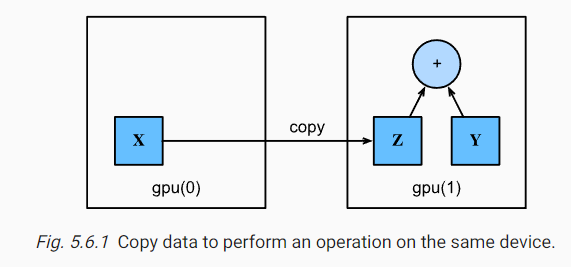

In [48]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [49]:
Z = X.cuda(1)
print(X)
print(Z)

RuntimeError: ignored

In [ ]:
Y + Z

In [ ]:
Z.cuda(1) is Z

### Neural Networks and GPUs

In [ ]:
net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize(ctx=try_gpu())

In [ ]:
net(X)

In [ ]:
net[0].weight.data().ctx

### Summary



*   Kita dapat menentukan pernyimpanan dan perhitungan, seperti GPU atau CPU. Secara default, data dibuat dalam memori utama dan kemudian gunakan CPU untuk perhitungan.

*   Kerangka kerja yang mendalam membutuhkan semua input data untuk perhitungan berada pada perangkat yang sama, baik itu CPU atau GPU yang sama.
*   Kesalahan: menghitung kerugian untuk setiap minibatch pada GPU dan melaporkannya kembali ke pengguna pada baris perintah (atau mencatatnya dalam numpy ndarray) akan memicu kunci interpreter global yang menghalangi semua GPU. Lebih baik mengalokasikan memori untuk masuk ke dalam GPU dan hanya memindahkan log yang lebih besar.


*   List item

